In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

from statistics import mean
import random
import csv
import time

import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')
sn.set_style("whitegrid")
%matplotlib inline


from process import concatenator, load_data_paths, gen_rawData
from process import normaliseTestData, normaliseTrainData, plot_confusion_matrix, segment_df, getInputVector

TrainingVector shape (3598, 360)
Label Train shape (3598,)
TestingVector shape (538, 360)
Label Test shape (538,)


## Constants 

In [2]:
TRAIN_FILEPATH = "./capstone_data/train/*.csv"
TEST_FILEPATH = "./capstone_data/test/*.csv"

DANCE_TO_NUM_MAP = {'dab': 0, 'jamesbond': 1, 'mermaid': 2}

DANCE_MOVES = ["jamesbond", "dab", "mermaid"]
IN_FEATURES = 360
OUT_FEATURES = 3
HIDDEN_LAYER_1_NODES = 200
HIDDEN_LAYER_2_NODES = 80
K = 12
EPOCHS = 50
TRAIN_BATCH_SIZE = 108
TEST_BATCH_SIZE = 40
LEARNING_RATE = 0.01

NUM_TO_DANCE_MAP = {0: 'dab', 1: 'jamesbond', 2: 'mermaid'}

## Load Dataset

In [3]:
raw_train_df = concatenator(gen_rawData(load_data_paths(TRAIN_FILEPATH)))
raw_test_df = concatenator(gen_rawData(load_data_paths(TEST_FILEPATH)))
# filter_signal(raw_train_df)
# filter_signal(raw_test_df)
TRAIN_MAX = normaliseTrainData(raw_train_df)
normaliseTestData(raw_test_df, TRAIN_MAX)
raw_test_df["target"] = raw_test_df["dance"].map(DANCE_TO_NUM_MAP)
raw_train_df["target"] = raw_train_df["dance"].map(DANCE_TO_NUM_MAP)
test_segs, lbl_test = segment_df(raw_test_df, "target")
train_segs, lbl_train = segment_df(raw_train_df, "target")
training_X = getInputVector(train_segs)
testing_X = getInputVector(test_segs)
print("TrainingVector shape", training_X.shape)
print("Label Train shape", lbl_train.shape )
print("TestingVector shape", testing_X.shape)
print("Label Test shape", lbl_test.shape )

X_train = torch.FloatTensor(training_X)
X_test = torch.FloatTensor(testing_X)
y_train = torch.LongTensor(lbl_train)
y_test = torch.LongTensor(lbl_test)
# X_test

TrainingVector shape (3598, 360)
Label Train shape (3598,)
TestingVector shape (538, 360)
Label Test shape (538,)


## Multi-Layer Perceptron Model

In [4]:
class Model(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

#### Instantiate Model class using default parameters

In [5]:
torch.manual_seed(32)
mlp = Model(in_features=IN_FEATURES, h1=HIDDEN_LAYER_1_NODES, h2=HIDDEN_LAYER_2_NODES, out_features=OUT_FEATURES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

#### 10-fold Stratified Cross Validation 

In [6]:
skfcv = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)
training_loss = {}
val_acc = []

# per fold 
for fold, (train_index, test_index) in enumerate(skfcv.split(X_train, y_train)):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    train_combined = TensorDataset(x_train_fold, y_train_fold)
    test_combined = TensorDataset(x_test_fold, y_test_fold)
    trainloader = DataLoader(train_combined, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    testloader = DataLoader(test_combined, batch_size=TEST_BATCH_SIZE, shuffle=False)
    # per epoch
    for i in range(EPOCHS): 
        i+=1
        # per batch 
        losses = [] 
        val_correct_preds = 0
        count = 0 
        for batch_idx, (data, target) in enumerate(trainloader):
            mlp.train()
             
            # training 
            y_pred = mlp.forward(data)
            loss = criterion(y_pred, target)
            losses.append(loss)
            
            # backtracking 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
        # validating 
        with torch.no_grad():
            mlp.eval()
            for val_batch_idx, (val_data, val_target) in enumerate(testloader):
                y_out = mlp.forward(val_data)
                for row in range(y_out.shape[0]):
                    if y_out[row].argmax() == val_target[row]:
                        val_correct_preds += 1
                    count += 1
                    
    # per fold         
    with torch.no_grad():
        training_loss[fold] = np.array(losses).mean()
        print("-----------------------")
        print(f"fold: {fold} , training_loss: {training_loss[fold]}")
        print(f"fold: {fold}, {val_correct_preds} out of {count} = {100*val_correct_preds/count:.2f}% correct")
        print("-----------------------")
        val_acc.append(100*val_correct_preds/count)
        count = 0

print()
print("Done Training")
print("Max Validation Accuracy: ",  np.array(val_acc).max())

-----------------------
fold: 0 , training_loss: 4.842136149818543e-06
fold: 0, 299 out of 300 = 99.67% correct
-----------------------
-----------------------
fold: 1 , training_loss: 4.761248874274315e-06
fold: 1, 298 out of 300 = 99.33% correct
-----------------------
-----------------------
fold: 2 , training_loss: 0.0001461943465983495
fold: 2, 299 out of 300 = 99.67% correct
-----------------------
-----------------------
fold: 3 , training_loss: 4.353653275757097e-05
fold: 3, 300 out of 300 = 100.00% correct
-----------------------
-----------------------
fold: 4 , training_loss: 1.6949064956861548e-05
fold: 4, 300 out of 300 = 100.00% correct
-----------------------
-----------------------
fold: 5 , training_loss: 7.241239472932648e-06
fold: 5, 300 out of 300 = 100.00% correct
-----------------------
-----------------------
fold: 6 , training_loss: 3.3928681659745052e-06
fold: 6, 300 out of 300 = 100.00% correct
-----------------------
-----------------------
fold: 7 , training

#### Mean Loss per fold 

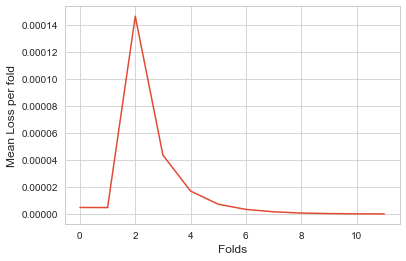

In [7]:
with torch.no_grad():
    y_axis  = training_loss.values()
    plt.plot(range(K), y_axis)
    plt.ylabel('Mean Loss per fold')
    plt.xlabel('Folds')

## Evaluation 

In [8]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    start_time = time.time()
    y_val = mlp.forward(X_test)
    print("--- %s execution time in seconds ---" % (time.time() - start_time))
    loss = criterion(y_val, y_test)
    print(f'Loss with test set : {loss:.8f}')

--- 0.03625607490539551 execution time in seconds ---
Loss with test set : 0.80680746



513 out of 538 = 95.35% correct
Confusion matrix, without normalization
tensor([[160,  22,   0],
        [  0, 179,   0],
        [  2,   1, 174]])
Classification Report for MLP :
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       182
           1       0.89      1.00      0.94       179
           2       1.00      0.98      0.99       177

    accuracy                           0.95       538
   macro avg       0.96      0.95      0.95       538
weighted avg       0.96      0.95      0.95       538



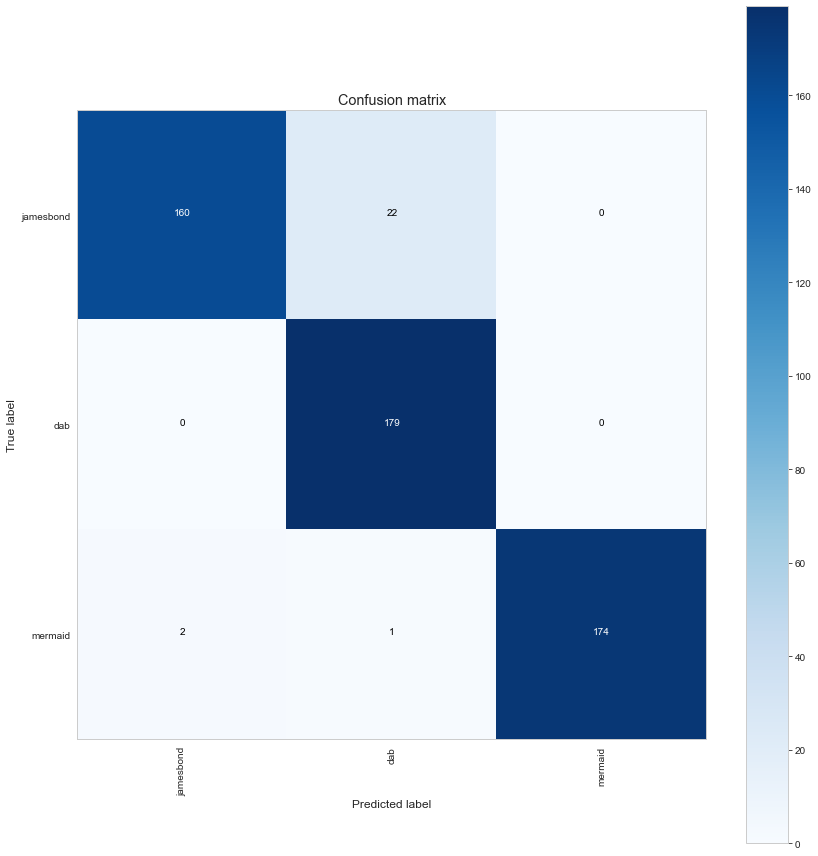

In [9]:
with torch.no_grad():
    # checking accuracy on test dataset 
    preds = []
    correct = 0
    for i,data in enumerate(X_test):
        y_val = mlp.forward(data)
        preds.append(y_val.argmax().item())
        if y_val.argmax().item() == y_test[i]:
            correct += 1
    print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
    y_preds = torch.tensor(preds, dtype = torch.int64)
    stacked = torch.stack((y_test,y_preds),dim=1)

    # confusion matrix generation 
    cmt = torch.zeros(OUT_FEATURES,OUT_FEATURES, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1  
    
    plt.figure(figsize=(12,12))
    plot_confusion_matrix(cmt, DANCE_MOVES)
    
    print("Classification Report for MLP :")
    print(classification_report(y_test, y_preds))

In [10]:
# model weights 
with torch.no_grad():
    mlp_params = {}
    for name, param in mlp.named_parameters():
        mlp_params[name] = param.numpy().copy().tolist()
        
    print(mlp_params.keys())
    for key in mlp_params.keys(): 
        print(f"{key} : {len(mlp_params[key])} neurons in {key} layer")
        print(f" number of connections  : {len(mlp_params[key])} * {np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size} = {len(mlp_params[key]) * np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size } ")

    # save model weights 
    with open('mlp.csv', 'w') as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in mlp_params.items():
           writer.writerow([key, value])

dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
fc1.weight : 200 neurons in fc1.weight layer
 number of connections  : 200 * 360 = 72000 
fc1.bias : 200 neurons in fc1.bias layer
 number of connections  : 200 * 1 = 200 
fc2.weight : 80 neurons in fc2.weight layer
 number of connections  : 80 * 200 = 16000 
fc2.bias : 80 neurons in fc2.bias layer
 number of connections  : 80 * 1 = 80 
out.weight : 3 neurons in out.weight layer
 number of connections  : 3 * 80 = 240 
out.bias : 3 neurons in out.bias layer
 number of connections  : 3 * 1 = 3 


## Save & Load Model

In [11]:
torch.save(mlp.state_dict(), 'MLPW9.pt')
loaded_model = Model(in_features=IN_FEATURES,h1=HIDDEN_LAYER_1_NODES, h2=HIDDEN_LAYER_2_NODES, out_features=OUT_FEATURES) 
loaded_model.load_state_dict(torch.load('MLPW9.pt'))
loaded_model.eval()

Model(
  (fc1): Linear(in_features=360, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (out): Linear(in_features=80, out_features=3, bias=True)
)

In [12]:
# loss when loaded model is run on test dataset 
with torch.no_grad():
    y_val = loaded_model.forward(X_test)
    loss = criterion(y_val, y_test)
    print(f'{loss:.8f}')

0.80680746


In [24]:
# # run model on a random sample row of the test dataset 
# random.seed(899)
# random_int = random.randint(0, len(testing_X))
# random_input = torch.FloatTensor(testing_X[random_int])
# print(random_input)
# print(random_input.shape)

random_input = torch.FloatTensor([[-1.654000e-01, -1.654000e-01, -1.732000e-01, -8.000000e-04,
       -8.000000e-04, -9.000000e-04, -7.000000e-04, -1.320000e-02,
       -1.410000e-02, -1.654000e-01, -1.654000e-01, -1.654000e-01,
       -7.000000e-04, -7.000000e-04, -8.000000e-04, -7.000000e-04,
       -1.320000e-02, -1.600000e-02, -2.756000e-01, -3.071000e-01,
       -4.331000e-01, -1.900000e-03, -1.200000e-03, -1.000000e-03,
       -8.000000e-04, -1.920000e-02, -2.120000e-02, -2.598000e-01,
       -1.575000e-01, -9.450000e-02,  3.000000e-04,  8.000000e-04,
        9.000000e-04,  8.000000e-04,  1.200000e-02,  5.800000e-03,
       -2.598000e-01, -2.598000e-01, -2.835000e-01, -1.100000e-03,
        3.500000e-03,  3.700000e-03,  3.100000e-03,  5.990000e-02,
        6.480000e-02,  7.953000e-01,  7.953000e-01,  7.874000e-01,
        3.400000e-03,  3.500000e-03,  3.700000e-03,  3.100000e-03,
        5.990000e-02,  6.410000e-02,  7.874000e-01,  7.874000e-01,
        7.874000e-01,  3.400000e-03,  3.500000e-03, -3.300000e-03,
       -2.700000e-03, -4.970000e-02, -5.320000e-02, -7.795000e-01,
       -8.504000e-01, -8.504000e-01,  3.400000e-03,  3.500000e-03,
        2.700000e-03,  1.300000e-03,  1.800000e-03, -1.220000e-02,
       -2.283000e-01, -2.283000e-01, -1.654000e-01,  7.000000e-04,
        1.900000e-03,  2.000000e-03, -1.900000e-03, -3.770000e-02,
        1.300000e-03,  2.360000e-02,  2.360000e-02,  2.360000e-02,
        1.000000e-04,  1.000000e-04,  1.000000e-04,  1.000000e-04,
        1.200000e-03,  1.300000e-03,  1.570000e-02,  1.570000e-02,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  1.030000e-02,  4.173000e-01,
        4.567000e-01,  4.567000e-01,  9.000000e-04,  9.000000e-04,
        1.300000e-03,  1.400000e-03,  2.750000e-02,  2.820000e-02,
        2.520000e-01,  1.732000e-01,  1.570000e-02,  0.000000e+00,
       -2.000000e-04, -2.000000e-04, -2.000000e-04,  3.000000e-03,
        1.350000e-02,  2.362000e-01,  3.543000e-01,  3.543000e-01,
        9.000000e-04,  1.100000e-03,  1.000000e-03, -1.100000e-03,
       -4.070000e-02, -4.490000e-02, -7.559000e-01, -7.559000e-01,
       -6.378000e-01, -2.800000e-03, -3.000000e-03, -3.200000e-03,
       -1.800000e-03,  1.437000e-01,  1.738000e-01,  2.236200e+00,
        5.354300e+00,  9.378000e+00,  1.488000e-01,  1.534000e-01,
       -3.640000e-02, -4.494000e-01, -1.083710e+01, -1.160870e+01,
       -1.397559e+02, -1.397559e+02, -1.492835e+02, -6.937000e-01,
       -7.556000e-01, -7.945000e-01, -4.906000e-01, -6.517400e+00,
       -3.595900e+00,  1.440160e+01,  6.677170e+01,  1.343622e+02,
        7.879000e-01,  8.897000e-01,  9.356000e-01,  7.702000e-01,
        1.320000e-02,  1.410000e-02, -2.677000e-01, -2.677000e-01,
       -1.811000e-01, -5.000000e-04,  2.300000e-03,  2.400000e-03,
        2.200000e-03,  3.000000e-03,  3.200000e-03, -1.811000e-01,
       -2.126000e-01, -6.929000e-01, -3.000000e-03,  5.300000e-03,
        5.500000e-03, -3.870000e-02, -6.665300e+00, -7.139800e+00,
       -5.653540e+01, -2.659060e+01, -4.094500e+00, -1.780000e-02,
       -9.580000e-02, -1.051000e-01, -8.650000e-02, -2.808000e-01,
        9.551000e-01,  1.172440e+01, -9.755900e+00, -9.755900e+00,
       -4.240000e-02,  4.510000e-02,  1.881000e-01,  1.752000e-01,
        3.433500e+00,  3.344500e+00,  4.105510e+01,  2.451180e+01,
        5.039000e-01,  8.100000e-03,  1.340000e-02,  1.410000e-02,
        1.120000e-02,  1.257000e-01,  2.120000e-02, -9.450000e-02,
       -9.450000e-02,  4.724000e-01,  2.600000e-03,  6.400000e-03,
        7.300000e-03,  5.800000e-03,  1.138000e-01,  1.219000e-01,
        1.866100e+00,  9.669300e+00,  3.952760e+01,  2.224000e-01,
        2.292000e-01, -1.457000e-01, -3.178000e-01, -6.227500e+00,
       -6.403500e+00, -6.586610e+01, -6.586610e+01, -9.364570e+01,
       -5.172000e-01, -5.331000e-01, -5.234000e-01, -3.139000e-01,
       -2.965900e+00,  2.226000e-01,  4.067720e+01,  9.529920e+01,
        1.373937e+02,  6.602000e-01,  7.612000e-01,  8.004000e-01,
        4.000000e-04,  1.620000e-02,  3.010000e-02,  5.354000e-01,
        6.929000e-01,  7.795000e-01,  3.400000e-03,  3.400000e-03,
        3.500000e-03,  3.000000e-03,  6.110000e-02,  7.180000e-02,
        9.606000e-01,  1.055100e+00,  1.133900e+00,  5.100000e-03,
        5.600000e-03,  8.400000e-03,  1.510000e-02,  5.772000e-01,
        7.030000e-01,  8.629900e+00,  4.291300e+00, -5.197000e-01,
       -2.040000e-02, -3.580000e-02, -5.450000e-02, -6.410000e-02,
       -1.735300e+00, -2.436200e+00, -3.589760e+01, -4.018900e+01,
       -4.211020e+01, -1.831000e-01, -1.789000e-01, -1.643000e-01,
       -1.070000e-01, -1.485600e+00, -8.326000e-01, -1.220500e+00,
       -7.900000e-03, -7.900000e-03, -0.000000e+00, -0.000000e+00,
        0.000000e+00,  1.000000e-04,  2.400000e-03,  2.600000e-03,
        2.360000e-02, -1.570000e-02, -1.570000e-02, -1.000000e-04,
       -1.000000e-04, -2.000000e-04, -2.000000e-04,  3.600000e-03,
        3.800000e-03, -4.488000e-01, -4.181100e+00, -4.181100e+00,
       -1.200000e-02, -5.700000e-03, -1.400000e-03, -1.200000e-03,
       -8.860000e-02, -9.490000e-02, -1.055100e+00, -3.940000e-02,
        6.614000e-01,  2.900000e-03, -1.130000e-02, -1.180000e-02,
       -9.700000e-03, -7.540000e-02,  2.820000e-02,  2.535400e+00,
        2.535400e+00,  2.338600e+00,  1.020000e-02,  5.400000e-03,
        1.000000e-04,  1.000000e-04,  1.200000e-03, -1.300000e-03,
       -3.940000e-02, -4.720000e-02, -4.720000e-02, -1.000000e-04,
       -1.000000e-04, -0.000000e+00, -1.000000e-04, -6.000000e-04,
       -6.000000e-04,  1.181000e-01,  1.181000e-01,  1.339000e-01,
        1.200000e-03,  1.900000e-03,  6.600000e-03,  5.500000e-03,
       -7.070000e-02, -5.164000e-01, -7.220500e+00, -7.220500e+00,
       -7.220500e+00, -3.230000e-02, -3.690000e-02, -4.070000e-02,
       -3.510000e-02, -6.874000e-01, -6.806000e-01, -7.992100e+00,
       -6.189000e+00, -3.236200e+00, -1.800000e-03,  2.820000e-02,
        4.000000e-02,  3.740000e-02,  7.437000e-01,  7.967000e-01]])
with torch.no_grad():
    print(loaded_model(random_input))
    print()
    print(loaded_model(random_input).max())
    print(loaded_model(random_input).argmax().item())
    print(f"Predicted Output: {NUM_TO_DANCE_MAP[loaded_model(random_input).argmax().item()]}")
#     print(f"Actual Output: {NUM_TO_DANCE_MAP[y_test[random_int].item()]}")

tensor([[ 244.0130, -833.7693,  -39.2507]])

tensor(244.0130)
0
Predicted Output: dab


In [14]:
# save test dataset
with torch.no_grad(): 
    x = X_test.numpy().copy().tolist()
    np.savetxt("X_test.csv", x, delimiter=",")
    y = y_test.numpy().copy().tolist()
    np.savetxt("y_test.csv", y, delimiter=",")

In [15]:
TRAIN_MAX

{'acc_X': 1.27,
 'acc_Y': 1.27,
 'acc_Z': 1.27,
 'gyro_X': 292.05,
 'gyro_Y': 283.31,
 'gyro_Z': 269.42,
 'yaw': 327.28,
 'pitch': 16.7,
 'roll': 15.59}